## License Information
---

This file is distributed as part of `hvsrpy`, a Python package for horizontal-to-vertical spectral ratio processing.

    Copyright (C) 2019-2020 Joseph P. Vantassel (jvantassel@utexas.edu)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _hvsrpy_ and this notebook
---

`hvsrpy` is a Python package for performing horizontal-to-vertical spectral ratio
(HVSR) processing. `hvsrpy` was developed by Joseph P. Vantassel with
contributions from Dana M. Brannon under the supervision of Professor Brady R.
Cox at The University of Texas at Austin.

If you use _hvsrpy_ in your research or consulting, we ask you please cite the following:

>Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo.
[http://doi.org/10.5281/zenodo.3666956](http://doi.org/10.5281/zenodo.3666956)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for `hvsrpy`, please use the citation tool on the `hvsrpy`
[archive](http://doi.org/10.5281/zenodo.3666956)._

The automated frequency-domain window-rejection algorithm and lognormal statistics
implemented in `hvsrpy` were developed by Tianjian Cheng under the supervision of
Professor Brady R. Cox at The University of Texas at Austin. To
recognize their original work please cite the follwing:

> Cox, B. R., Cheng, T., Vantassel, J. P., & Manuel, L. (2020). "A statistical
> representation and frequency-domain window-rejection algorithm for single-station
> HVSR measurements. Geophysical Journal International, 221(3), 2170–2183.
> https://doi.org/10.1093/gji/ggaa119


This notebook also provides automatic checking of the SESAME (2004) reliability
and clarity critera. To recognize their original work please also cite the following:

> SESAME. (2004). Guidelines for the Implementation of the H/V Spectral Ratio Technique on Ambient Vibrations
> Measurements, Processing, and Interpretation. European Commission - Research General Directorate, 62,
> European Commission - Research General Directorate.

## Getting Started
---
1. Install _hvsrpy_ and its dependencies, with `pip install hvsrpy`. If you are not familiar with `pip`, a useful tutorial can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__
2. Try analyzing the four provided examples. The names of these files have been written and commented out in the section _Time Domain Settings_ for your convenience. __(~15 minutes)__
3. Try one of your own _miniseed_ files and confirm that, when the same settings are used, the result from _hvsrpy_ exactly matches that of Geopsy. If you get an error related to the _miniseed_ file this likely means it does not conform to the _SEED_ standard (refer to the [hvsrpy documentation](https://hvsrpy.readthedocs.io/en/stable/) for details). __(~15 minutes)__

Happy Processing!

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import hvsrpy
from hvsrpy import utils

## Time Domain Settings
---

In [2]:
# Input file name (may be a relative or full path).
# file_name = "UT.STN11.A2_C50.miniseed"
file_name = "UT.STN11.A2_C150.miniseed"
# file_name = "UT.STN12.A2_C50.miniseed"
# file_name = "UT.STN12.A2_C150.miniseed"

# Window length in seconds. In general low frequency peaks require longer window lengths.
# See the SESAME guidelines for specific window length recommendations.
windowlength = 60

# Boolean to control whether Butterworth filter is applied. 
# Geopsy does not apply a bandpass filter.
filter_bool = False        
# Low-cut frequency for bandpass filter.
flow = 0.1                   
# High-cut frequency for bandpass filter.
fhigh = 30                   
# Filter order.
forder = 5

# Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
width = 0.1

## Frequency Domain Settings
---

In [3]:
# Konno and Ohmachi smoothing constant. 40 is recommended.
bandwidth = 40

# Minimum frequency after resampling
minf = 0.1  
# Maximum frequency after resampling
maxf = 50
# Number of frequencies after resampling
nf = 200
# Type of resampling {'log', 'linear'}
res_type = 'log'

# Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
f_low = None
f_high = None

## HVSR Settings
---

In [4]:
# Method for combining horizontal components {"squared-average", "geometric-mean", "single-azimuth"}.
# Geopsy's default is "squared-average" -> "geometric-mean" is recommended.
method = "geometric-mean"
# If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
azimuth = 0

# Boolean to control whether frequency domain rejection proposed by Cox et al. (2020) is applied.
# Geopsy does not offer this functionality.
rejection_bool = True
# Number of standard deviations to consider during rejection. Smaller values will reject more windows -> 2 is recommended.
n = 2
# Maximum number of iterations to perform for rejection -> 50 is recommended.
n_iteration = 50

# Distribution of f0 {"lognormal", "normal"}. Geopsy default "normal" -> "lognormal" is recommended.
distribution_f0 = "lognormal"
# Distribution of mean curve {"lognormal", "normal"}. Geopsy default "lognormal" -> "lognormal" is recommended.
distribution_mc = "lognormal"

## Plot Settings
---

In [5]:
# Manually set the ylimits of the HVSR figures. Default is None so limits will be set automatically.
ymin, ymax = 0, 10

## Perform Calculation
---

Elapsed Time: 1.17 seconds

Statistics before rejection:


,Lognormal Median,Lognormal Standard Deviation
"Fundamental Site Frequency, f0",0.46,0.67
"Fundamental Site Period, T0",2.15,0.67



Analysis summary:


,
Window length,60s
No. of windows,60
Number of iterations to convergence,7 of 50 allowed
No. of rejected windows,22



Statistics after rejection:


,Lognormal Median,Lognormal Standard Deviation
"Fundamental Site Frequency, f0",0.72,0.11
"Fundamental Site Period, T0",1.40,0.11


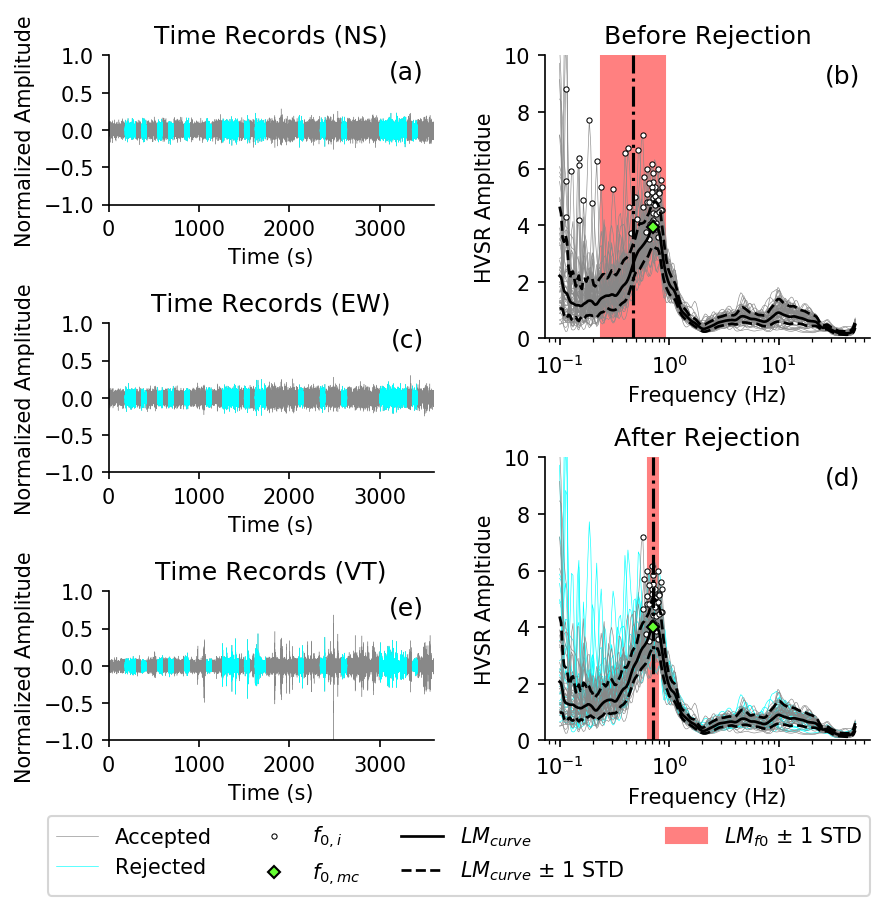

In [6]:
fig = plt.figure(figsize=(6,6), dpi=150)
gs = fig.add_gridspec(nrows=6,ncols=6)

ax0 = fig.add_subplot(gs[0:2, 0:3])
ax1 = fig.add_subplot(gs[2:4, 0:3])
ax2 = fig.add_subplot(gs[4:6, 0:3])

if rejection_bool:
    ax3 = fig.add_subplot(gs[0:3, 3:6])
    ax4 = fig.add_subplot(gs[3:6, 3:6])
else:
    ax3 = fig.add_subplot(gs[0:3, 3:6])
    ax4 = False

start = time.time()
sensor = hvsrpy.Sensor3c.from_mseed(file_name)
bp_filter = {"flag":filter_bool, "flow":flow, "fhigh":fhigh, "order":forder}
resampling = {"minf":minf, "maxf":maxf, "nf":nf, "res_type":res_type}
hv = sensor.hv(windowlength, bp_filter, width, bandwidth, resampling, method, f_low=f_low, f_high=f_high, azimuth=azimuth)
end = time.time()
print(f"Elapsed Time: {str(end-start)[0:4]} seconds")

individual_width = 0.3
median_width = 1.3
for ax, title in zip([ax3, ax4], ["Before Rejection", "After Rejection"]):
    # Rejected Windows
    if title=="After Rejection":
        if len(hv.rejected_window_indices):
            label = "Rejected"
            for amp in hv.amp[hv.rejected_window_indices]:
                ax.plot(hv.frq, amp, color='#00ffff', linewidth=individual_width, zorder=2, label=label)
                label=None
            
    # Accepted Windows
    label="Accepted"
    for amp in hv.amp[hv.valid_window_indices]:
        ax.plot(hv.frq, amp, color='#888888', linewidth=individual_width,
                label = label if title=="Before Rejection" else "")
        label=None
    
    # Window Peaks
    ax.plot(hv.peak_frq, hv.peak_amp, linestyle="", zorder=2,
            marker='o', markersize=2.5, markerfacecolor="#ffffff", markeredgewidth=0.5, markeredgecolor='k',
            label="" if title=="Before Rejection" and rejection_bool else r"$f_{0,i}$")
    
    # Peak Mean Curve
    ax.plot(hv.mc_peak_frq(distribution_mc), hv.mc_peak_amp(distribution_mc), linestyle="", zorder=4,
            marker='D', markersize=4, markerfacecolor='#66ff33', markeredgewidth=1, markeredgecolor='k', 
            label = "" if title=="Before Rejection" and rejection_bool else r"$f_{0,mc}$")
    
    # Mean Curve
    label = r"$LM_{curve}$" if distribution_mc=="lognormal" else "Mean"   
    ax.plot(hv.frq, hv.mean_curve(distribution_mc), color='k', linewidth=median_width,
            label="" if title=="Before Rejection" and rejection_bool else label)
    
    # Mean +/- Curve
    label = r"$LM_{curve}$"+" ± 1 STD" if distribution_mc=="lognormal" else "Mean ± 1 STD"
    ax.plot(hv.frq, hv.nstd_curve(-1, distribution_mc),
            color='k', linestyle='--', linewidth=median_width, zorder=3,
            label = "" if title=="Before Rejection" and rejection_bool else label)
    ax.plot(hv.frq, hv.nstd_curve(+1, distribution_mc),
            color='k', linestyle='--', linewidth=median_width, zorder=3)

    # f0 +/- STD
    if ymin is not None and ymax is not None:
        ax.set_ylim((ymin, ymax))
    label = r"$LM_{f0}$"+" ± 1 STD" if distribution_f0=="lognormal" else "Mean f0 ± 1 STD"    
    _ymin, _ymax = ax.get_ylim()
    ax.plot([hv.mean_f0_frq(distribution_f0)]*2, [_ymin, _ymax], linestyle="-.", color="#000000")
    ax.fill([hv.nstd_f0_frq(-1, distribution_f0)]*2 + [hv.nstd_f0_frq(+1, distribution_f0)]*2, [_ymin, _ymax, _ymax, _ymin], 
            color = "#ff8080",
            label="" if title=="Before Rejection" and rejection_bool else label)
    ax.set_ylim((_ymin, _ymax))
    
    ax.set_xscale('log')
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("HVSR Ampltidue")
    if rejection_bool:
        if title=="Before Rejection":
            print("\nStatistics before rejection:")
            hv.print_stats(distribution_f0)
            c_iter = hv.reject_windows(n, max_iterations=n_iteration, 
                                       distribution_f0=distribution_f0, distribution_mc=distribution_mc)
        elif title=="After Rejection":
            fig.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.51, 0), columnspacing=2)

            print("\nAnalysis summary:")  
            display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows", "Number of iterations to convergence", "No. of rejected windows"], 
                    data=[f"{windowlength}s", str(sensor.ns.nseries), f"{c_iter} of {n_iteration} allowed", str(sum(hv.rejected_window_indices))]))            
            print("\nStatistics after rejection:")
            hv.print_stats(distribution_f0)
    else:
        display(pd.DataFrame(columns=[""], index=["Window length", "No. of windows"], 
                         data=[f"{windowlength}s", str(sensor.ns.nseries)]))
        hv.print_stats(distribution_f0)
        fig.legend(loc="upper center", bbox_to_anchor=(0.77, 0.4))
        break
    ax.set_title(title)

norm_factor = sensor.normalization_factor
for ax, timerecord, name in zip([ax0,ax1,ax2], [sensor.ns, sensor.ew, sensor.vt], ["NS", "EW", "VT"]):
    ctime = timerecord.time
    amp = timerecord.amp/norm_factor
    ax.plot(ctime.T, amp.T, linewidth=0.2, color='#888888')
    ax.set_title(f"Time Records ({name})")
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xlim(0, windowlength*timerecord.nseries)
    ax.set_ylim(-1, 1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized Amplitude')
    ax.plot(ctime[hv.rejected_window_indices].T, amp[hv.rejected_window_indices].T, linewidth=0.2, color="cyan")

if rejection_bool:
    axs = [ax0, ax3, ax1, ax4, ax2]
else:
    axs = [ax0, ax3, ax1, ax2]
    
for ax, letter in zip(axs, list("abcde")):    
    ax.text(0.97, 0.97, f"({letter})", ha="right", va="top", transform=ax.transAxes, fontsize=12)
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)


fig.tight_layout(h_pad=1, w_pad=2, rect=(0,0.08,1,1))
plt.show()

## SESAME (2004) Reliability and Clarity Criteria
---

Please note that this functionality is still in the beta stage of development.
So please review the classification carefully before incorporating the results into your work.
If you believe you have found an error or if you wish to provide other feedback related to this functionality it is both welcomed and appreciated.

In [7]:
reliability = utils.sesame_reliability(hv.meta["Window Length"], len(hv.valid_window_indices), hv.frq, hv.mean_curve(), hv.std_curve(), search_limits=(f_low, f_high), verbose=1)
clarity = utils.sesame_clarity(hv.frq, hv.mean_curve(), hv.std_curve(), hv.std_f0_frq(distribution="normal"), search_limits=(f_low, f_high), verbose=1)

Assessing SESAME (2004) reliability criteria ... 
  Criteria i): Pass
  Criteria ii): Pass
  Criteria iii): Pass
  The chosen peak PASSES the peak reliability criteria, with 3 of 3.
Assessing SESAME (2004) clarity criteria ... 
  Criteria i): Pass
  Criteria ii): Pass
  Criteria iii): Pass
  Criteria iv): Fail
  Criteria v): Pass
  Criteria vi): Pass
  The chosen peak PASSES the peak clarity criteria, with 5 of 6.


## Save Figure to File
---

In [8]:
figure_name_out = "example_hvsr_figure.png"

fig.savefig(figure_name_out, dpi=300, bbox_inches='tight')
plt.close()
print("Figure saved successfully!")

Figure saved successfully!


## Save Results to Text File
---

In [9]:
file_name_out = "example_output_hvsrpy.hv"

hv.to_file(file_name_out, distribution_f0, distribution_mc, data_format="hvsrpy")
print("Results saved successfully!")

Results saved successfully!


## Save Results to Geopsy-Style Text File
---

In [10]:
file_name_out = "example_output_geopsy.hv"

hv.to_file(file_name_out, distribution_f0, distribution_mc, data_format="geopsy")
print("Results saved successfully!")

Results saved successfully!
